# От RNN к LSTM, GRU 

## Проблема долгосрочного запоминания и появление гейтов

Классическая RNN эффективно анализирует последовательности — например, предсказывает следующее слово. Но обучение RNN сопряжено с рядом трудностей, одна из них — слабая способность сети к долгосрочному запоминанию.

Проблема долгосрочного запоминания — это неспособность RNN сохранять информацию на длинных промежутках. Когда ошибка обратно распространяется во времени, токены, которые нейросеть видела много шагов назад, имеют малые значения градиентов и обновляются не очень эффективно.

Как результат, RNN плохо «помнит» события, случившиеся много шагов назад. Это можно считать эффектом от проблемы затухания градиентов. 

Частично эта проблема решается стабилизацией обучения, но можно использовать и дополнительные подходы.  

Чтобы дать нейросети возможность запоминать длинный контекст, были предложены архитектуры, которые используют гейты.

**Гейты** — специальные механизмы в архитектуре нейросети, которые позволяют ей избирательно сохранять или удалять информацию.  

Внутри ячеек для каждого шага последовательно вычисляются специальные векторы-гейты (все значения от 0 до 1), которые решают, какую часть информации пропустить дальше, а какую — отбросить. Благодаря такой выборочной «фильтрации» сеть приобретает способность учитывать полезные токены, даже если она «видела» их давно. 


# Архитектуры LSTM и GRU

## Добавление гейтов в классическую RNN привело к созданию архитектур LSTM и GRU. 

Разберёмся, как устроены гейты «под капотом» и как они встраиваются в RNN. 

### LSTM

**LSTM** (Long Short-Term Memory — англ. механизм длительной кратковременной памяти) — это архитектура, специально разработанная для решения проблемы долгосрочной зависимости. Она добавляет:

- cell state — состояние, в котором информация передаётся без сильных изменений;

<u>три гейта</u>: **забывающий** (forget gate), **входной** (input gate) и **выходной** (output gate).
    
- Забывающий (forget) гейт позволяет удалить устаревшую или нерелевантную информацию. Он решает: «Стоит ли забыть то, что мы уже знаем?».

- Входной (input) гейт фильтрует текущий вход. Он отвечает на вопрос: «Нужно ли сохранить новую информацию, которая только что пришла?».

- Выходной (output) гейт определяет, какую часть памяти использовать для генерации выхода. Он решает: «Что из внутренней памяти стоит выдать на следующем шаге?».

Таким образом, LSTM — это тоже рекуррентная нейронная сеть, но её рекуррентный блок дополнен гейтами — векторами, которые решают, что делать с полученной информацией.
Формулы для обработки токена на позиции $t$ выглядят так:

- Forget gate
$$
f_t​=σ(W_f​[h_{t−1}​,x_t​]+b_f​)
$$
- Input gate
$$
i_t​=σ(W_i​[h_{t−1}​,x_t​]+b_i​)
$$
$$
\tilde{C}_t​=tanh(W_C​[h_{t−1}​,x_t​]+b_C​)
$$
- Обновление состояния
$$
C_t​=f_t​⋅C_{t−1}​+i_t​⋅\tilde{C}_t​
$$
- Output gate
$$
o_t​=σ(W_o​[h_{t−1}​,x_t​]+b_o​)
$$
$$
h_t​=o_t​⋅tanh(C_t​)
$$
Здесь:

- $x_t$​ — вход в момент времени t (токен или эмбеддинг токена),

- $h_{t−1}$​ — скрытое состояние предыдущего шага,
    
- $σ$ — сигмоида (функция активации),
    
- $tanh$ — гиперболический тангенс (тоже функция активации).
    Визуализация

Отличный и очень глубокий вопрос! Давайте разберём **LSTM с математической точки зрения**, но **шаг за шагом**, чтобы было понятно **не только «что»**, но и **«почему именно так»**.

---

## 🧩 Главная цель: **решить проблему затухающих градиентов**

В обычной RNN обновление скрытого состояния:
$$
h_t = \tanh(W x_t + U h_{t-1} + b)
$$

При обратном распространении ошибки градиент проходит через цепочку производных:
$$
\frac{\partial h_t}{\partial h_{t-1}} = \text{diag}(1 - h_t^2) \cdot U
$$

Производная $\tanh$ — это $1 - \tanh^2$, которая **всегда ≤ 1**.  
Если умножать такие числа много раз → градиент **затухает экспоненциально**.

> 🔥 **Идея LSTM**: **не пропускать градиент через нелинейности**, а дать ему **прямой путь**.

---

## 💡 Ключевой трюк: **ячейка памяти (cell state) `C_t`**

LSTM вводит **дополнительное состояние** — `C_t` — которое **обновляется аддитивно**, а не через $\tanh$:

$$
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
$$

- $\odot$ — поэлементное умножение,
- $f_t, i_t$ — ворота (от 0 до 1),
- $\tilde{C}_t$ — новая информация.

### Почему это спасает градиент?

Посмотрим на производную $C_t$ по $C_{t-1}$:

$$
\frac{\partial C_t}{\partial C_{t-1}} = f_t
$$

Если $f_t \approx 1$ («ничего не забывать»), то:
$$
\frac{\partial C_t}{\partial C_{t-1}} \approx 1
$$

→ градиент **проходит без затухания** через всю последовательность!

> ✅ Это **главный математический секрет LSTM**: **аддитивное обновление** + **управляемый поток** через ворота.

---

## 🔑 Почему именно сигмоида в воротах?

Сигмоида: $\sigma(x) = \frac{1}{1 + e^{-x}} \in (0, 1)$

- Она **непрерывна и дифференцируема** → можно обучать через backprop.
- Выход в $[0, 1]$ → идеально для **масштабирования**:  
  - $0$ = «полностью забыть»,  
  - $1$ = «полностью сохранить».

> 🎯 Это **контролируемый "кран"**, который учится регулировать поток информации.

---

## 📐 Почему $\tilde{C}_t = \tanh(\dots)$?

- $\tanh$ даёт значения в $[-1, 1]$ → **ограниченный диапазон**.
- Это **стабилизирует обновления**: новые значения не взрываются.
- Но главное: **это не мешает градиенту**, потому что $\tilde{C}_t$ **умножается на \(i_t\)** и **добавляется**, а не заменяет `C_t`.

---

## 🔄 Почему обновление именно такое?

$$
C_t = \underbrace{f_t \odot C_{t-1}}_{\text{«что оставить»}} + \underbrace{i_t \odot \tilde{C}_t}_{\text{«что добавить»}}
$$

Это **естественная модель памяти**:
- Сначала **решаем, что забыть** из старого (`f_t`),
- Потом **решаем, что запомнить** нового (`i_t`),
- И **аккуратно комбинируем**.

> Это как редактировать заметку:  
> - стереть устаревшее,  
> - дописать новое.

---

## 📉 А как с градиентом в воротах?

Да, ворота (`f_t`, `i_t`) сами зависят от $h_{t-1}$, и их градиенты могут затухать.  
**Но!** Основной сигнал (через `C_t`) **не зависит от них напрямую** — он идёт **в обход**.

> 🧠 LSTM — это **два пути**:  
> - **быстрый путь** через `C_t` (градиент ≈ 1),  
> - **медленный путь** через `h_t` (градиент может затухать, но он вторичен).

---

## 📐 Почему $h_t = o_t \odot \tanh(C_t)$?

- `C_t` может быть большим → применяем $\tanh$, чтобы ограничить диапазон.
- Но **не используем `C_t` напрямую** — через **ворота вывода `o_t`**:
  - Решаем, **какую часть памяти показать** внешнему миру.

> Это важно: **внутренняя память (`C_t`)** и **внешнее состояние (`h_t`)** — разные вещи.

---

## 🧮 Пример численного обновления

Допустим:
- $C_{t-1} = [2.0, -1.5]$
- $f_t = [0.9, 0.1]$ → почти всё сохраняем из первого элемента, почти всё забываем из второго
- $i_t = [0.2, 0.8]$
- $\tilde{C}_t = [0.5, 1.0]$

Тогда:
$$
C_t = [0.9 \cdot 2.0 + 0.2 \cdot 0.5,\ 0.1 \cdot (-1.5) + 0.8 \cdot 1.0] = [1.8 + 0.1,\ -0.15 + 0.8] = [1.9,\ 0.65]
$$

→ Память **плавно обновилась**, не обнулилась и не взорвалась.

---

## ✅ Итог: почему именно эти формулы?

| Компонент | Почему так? |
|----------|-------------|
| **Аддитивное обновление `C_t`** | Чтобы градиент мог течь без затухания |
| **Сигмоида в воротах** | Чтобы плавно регулировать поток от 0 до 1 |
| **\(\tanh\) для \(\tilde{C}_t\)** | Чтобы новые значения были в ограниченном диапазоне |
| **Отдельное \(h_t\)** | Чтобы контролировать, что "показывать" из памяти |

> 🎯 LSTM — это **инженерное решение проблемы градиентов**, основанное на **контролируемом аддитивном обновлении памяти**.

Уточним более математически:

### 1. **Проблема затухающих градиентов**
> «От производной по произведению переходим к производной от суммы — это стабильнее» — **абсолютно верно!**

- В обычной RNN:  
  $ h_t = \tanh(W x_t + U h_{t-1}) $ → градиент проходит через цепочку **произведений** производных $\tanh'$, которые < 1 → экспоненциальное затухание.
- В LSTM:  
  $ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $ → градиент по $C_t$ к $C_{t-1}$ — это просто $f_t$, а если $f_t \approx 1$, то градиент ≈ 1 → **не затухает**.

👉 Это **ключевая математическая идея LSTM**.

---

### 2. **Вектор $f$ как «важность»**

- $f_t$ — это **не про координаты входа $x_t$**, а про **координаты ячейки памяти $C_{t-1}$**.
- Каждый элемент $f_t[i]$ говорит: **насколько сохранить i-ю компоненту старой памяти $C_{t-1}[i]$**.
- Это **не про вход**, а про **внутреннее состояние памяти**.

---

## ❓ Что такое $ W_f [h_{t-1}, x_t] $ — разберём подробно

Это **линейное преобразование**, и вот что оно означает:

### 1. **Конкатенация**:  
$$
[h_{t-1}, x_t] \in \mathbb{R}^{d_h + d_x}
$$
— это просто **объединение** предыдущего скрытого состояния и текущего входа в один вектор.

> Пример: если $h_{t-1}$ — 128-мерный, а $x_t$ — 768-мерный (BERT), то конкатенация — 896-мерный вектор.

### 2. **Матрица весов** \( W_f \):  
$$
W_f \in \mathbb{R}^{d_h \times (d_h + d_x)}
$$
— это обучаемая матрица, которая **проектирует** объединённый вектор в пространство размера $d_h$ (размер скрытого состояния).

### 3. **Результат**:  
$$
z_f = W_f [h_{t-1}, x_t] + b_f \in \mathbb{R}^{d_h}
$$
— это **логиты** (сырые оценки) для ворот забывания.

### 4. **Сигмоида**:  
$$
f_t = \sigma(z_f) \in (0, 1)^{d_h}
$$
— теперь у нас **маска**, которая говорит, **какие компоненты памяти сохранить**.

> 🔍 **Интуиция**: модель **смотрит на текущее слово и своё прошлое состояние**, и **решает**, что из старой памяти всё ещё актуально.

---

## 🧠 Как инициализируются состояния и веса?

### 1. **Начальные состояния** ($h_0$, $C_0$)
- Обычно **нулевые тензоры** формы `(num_layers, batch_size, hidden_dim)`.
- Иногда — обучаемые параметры (редко).
- При инференсе — всегда нули (если нет контекста).

### 2. **Веса** ($W_f$, $W_i$, $W_C$, $W_o$)
- Инициализируются **случайно**, но **умно**:
  - $W_f$, $W_i$, $W_o$ — часто **Xavier/Glorot uniform** или **Gaussian**.
  - $W_C$ (для $\tilde{C}_t$) — тоже Xavier.
  - Для рекуррентных весов ($U$ в RNN) — часто **orthogonal initialization** (особенно для $W_{hh}$ в LSTM).
- Смещения ($b_f$, $b_i$, $b_o$) — **нули**.
- Смещение для $b_C$ — **нули**.
- **Исключение**: иногда $b_f$ инициализируют **положительными значениями** (например, 1), чтобы **в начале обучения ничего не забывалось** (стабилизирует обучение).

> 💡 В PyTorch: `nn.LSTM` по умолчанию использует **Xavier для входных весов** и **orthogonal для рекуррентных**.

---

## 🔄 Кратко: что происходит на шаге `t`

1. Получаем $x_t$ и $h_{t-1}$.
2. Конкатенируем: $[h_{t-1}, x_t]$.
3. Пропускаем через 4 линейных преобразования → получаем $z_f$, $z_i$, $z_C$, $z_o$.
4. Применяем нелинейности:
   - $f_t = σ(z_f)$
   - $i_t = σ(z_i)$
   - $\tilde{C}_t = tanh(z_C)$
   - $o_t = σ(z_o)$
5. Обновляем память:  
   $ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $
6. Вычисляем выход:  
   $ h_t = o_t \odot \tanh(C_t) $

---

## 📌 Что важно запомнить

- **$W_f [h_{t-1}, x_t]$ — это просто полносвязный слой**, который "принимает решение" на основе прошлого и настоящего.
- **Градиент течёт через $C_t$ почти без изменений** — это главный трюк.
- **Веса инициализируются случайно, но разумно** (Xavier/orthogonal), а начальные состояния — нули.
- **$f_t$ управляет не входом, а памятью** — это важно!

---

Осталось только уточнить, **что именно масштабирует $f_t$** (память, а не вход), и **почему конкатенация** — это естественный способ дать модели доступ и к прошлому, и к настоящему.


Один шаг работы LSTM-ячейки схематически выглядит так: 

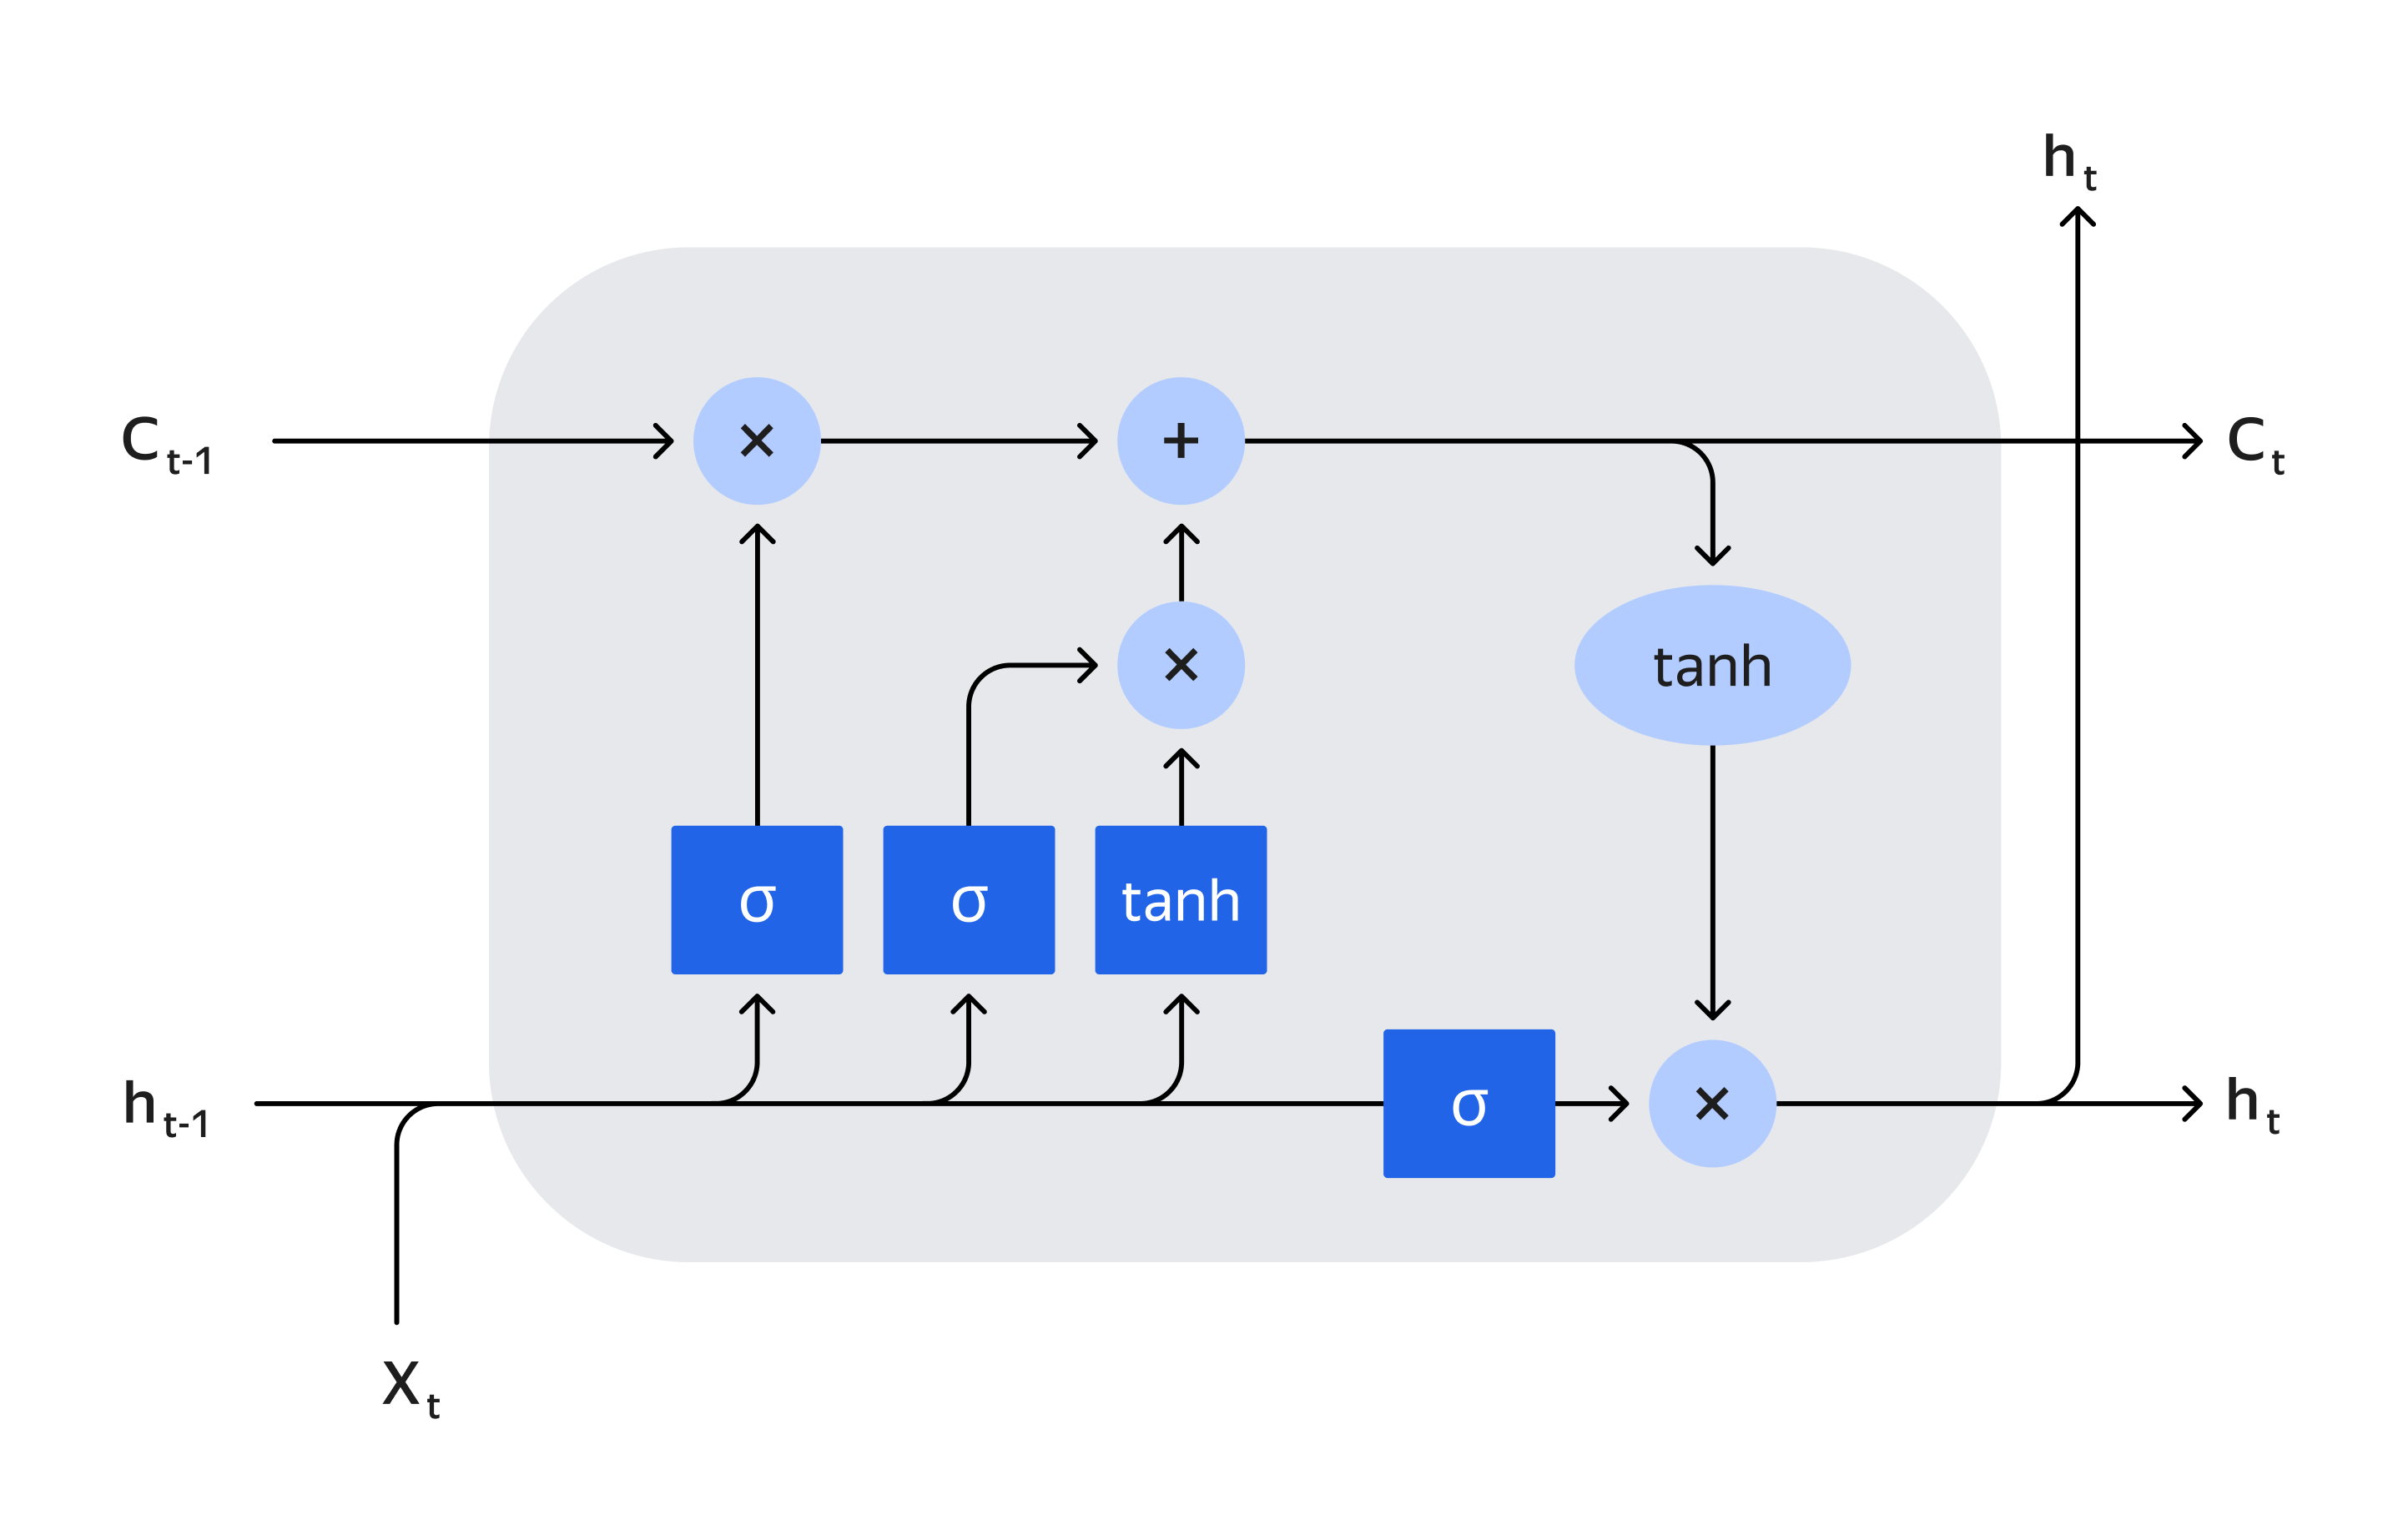

In [1]:
from IPython.display import Image
from ml_dl_experiments import settings

Image(settings.SOURCE_PATH+"ml_dl/RNN/LSTM.png", width=600, height=1000)

- Прошлое состояние $C_{t−1}$​ умножается на выход первого σ-блока (forget gate). 

- Параллельно входные данные $x_t$​ и предыдущее скрытое состояние $h_{t−1}$​ через tanh преобразуют входные значения, и

- затем второй σ-блок (input gate) выбирает, какую часть этих значений запомнить.

- Сложение двух результатов даёт текущее состояние $C_t$​. 

- Наконец, $C_t$​ через tanh и третий σ-блок (output gate) даёт выход $h_t$​.

# GRU

GRU (Gated Recurrent Unit) — более простая альтернатива LSTM. Она объединяет forget- и input-гейты в один update gate и вместо cell state использует только hidden state, при этом расчёты чуть сложнее, чем в классической RNN. Архитектура GRU проще LSTM, поэтому сети легче и быстрее обучаются, при этом сохраняют способность моделировать долгосрочные зависимости.

Рассмотрим, какие формулы скрываются «под капотом» GRU:

- Update gate
$$
z_t​=σ(W_z​[h_{t−1}​,x_t​]+b_z​)
$$
- Reset gate
$$
r_t​=σ(W_r​[h_{t−1}​,x_t​]+b_r​)
$$    
   
- Обновление состояния
$$
\tilde{h}_t​=tanh(W_h​[r_t​⋅h_{t−1}​,x_t​]+b_h​)
$$    
$$
h_t​=(1−z_t​)⋅h_{t−1}​+z_t​⋅\tilde{h}_t​
$$
Схема шага работы ячейки в архитектуре GRU:

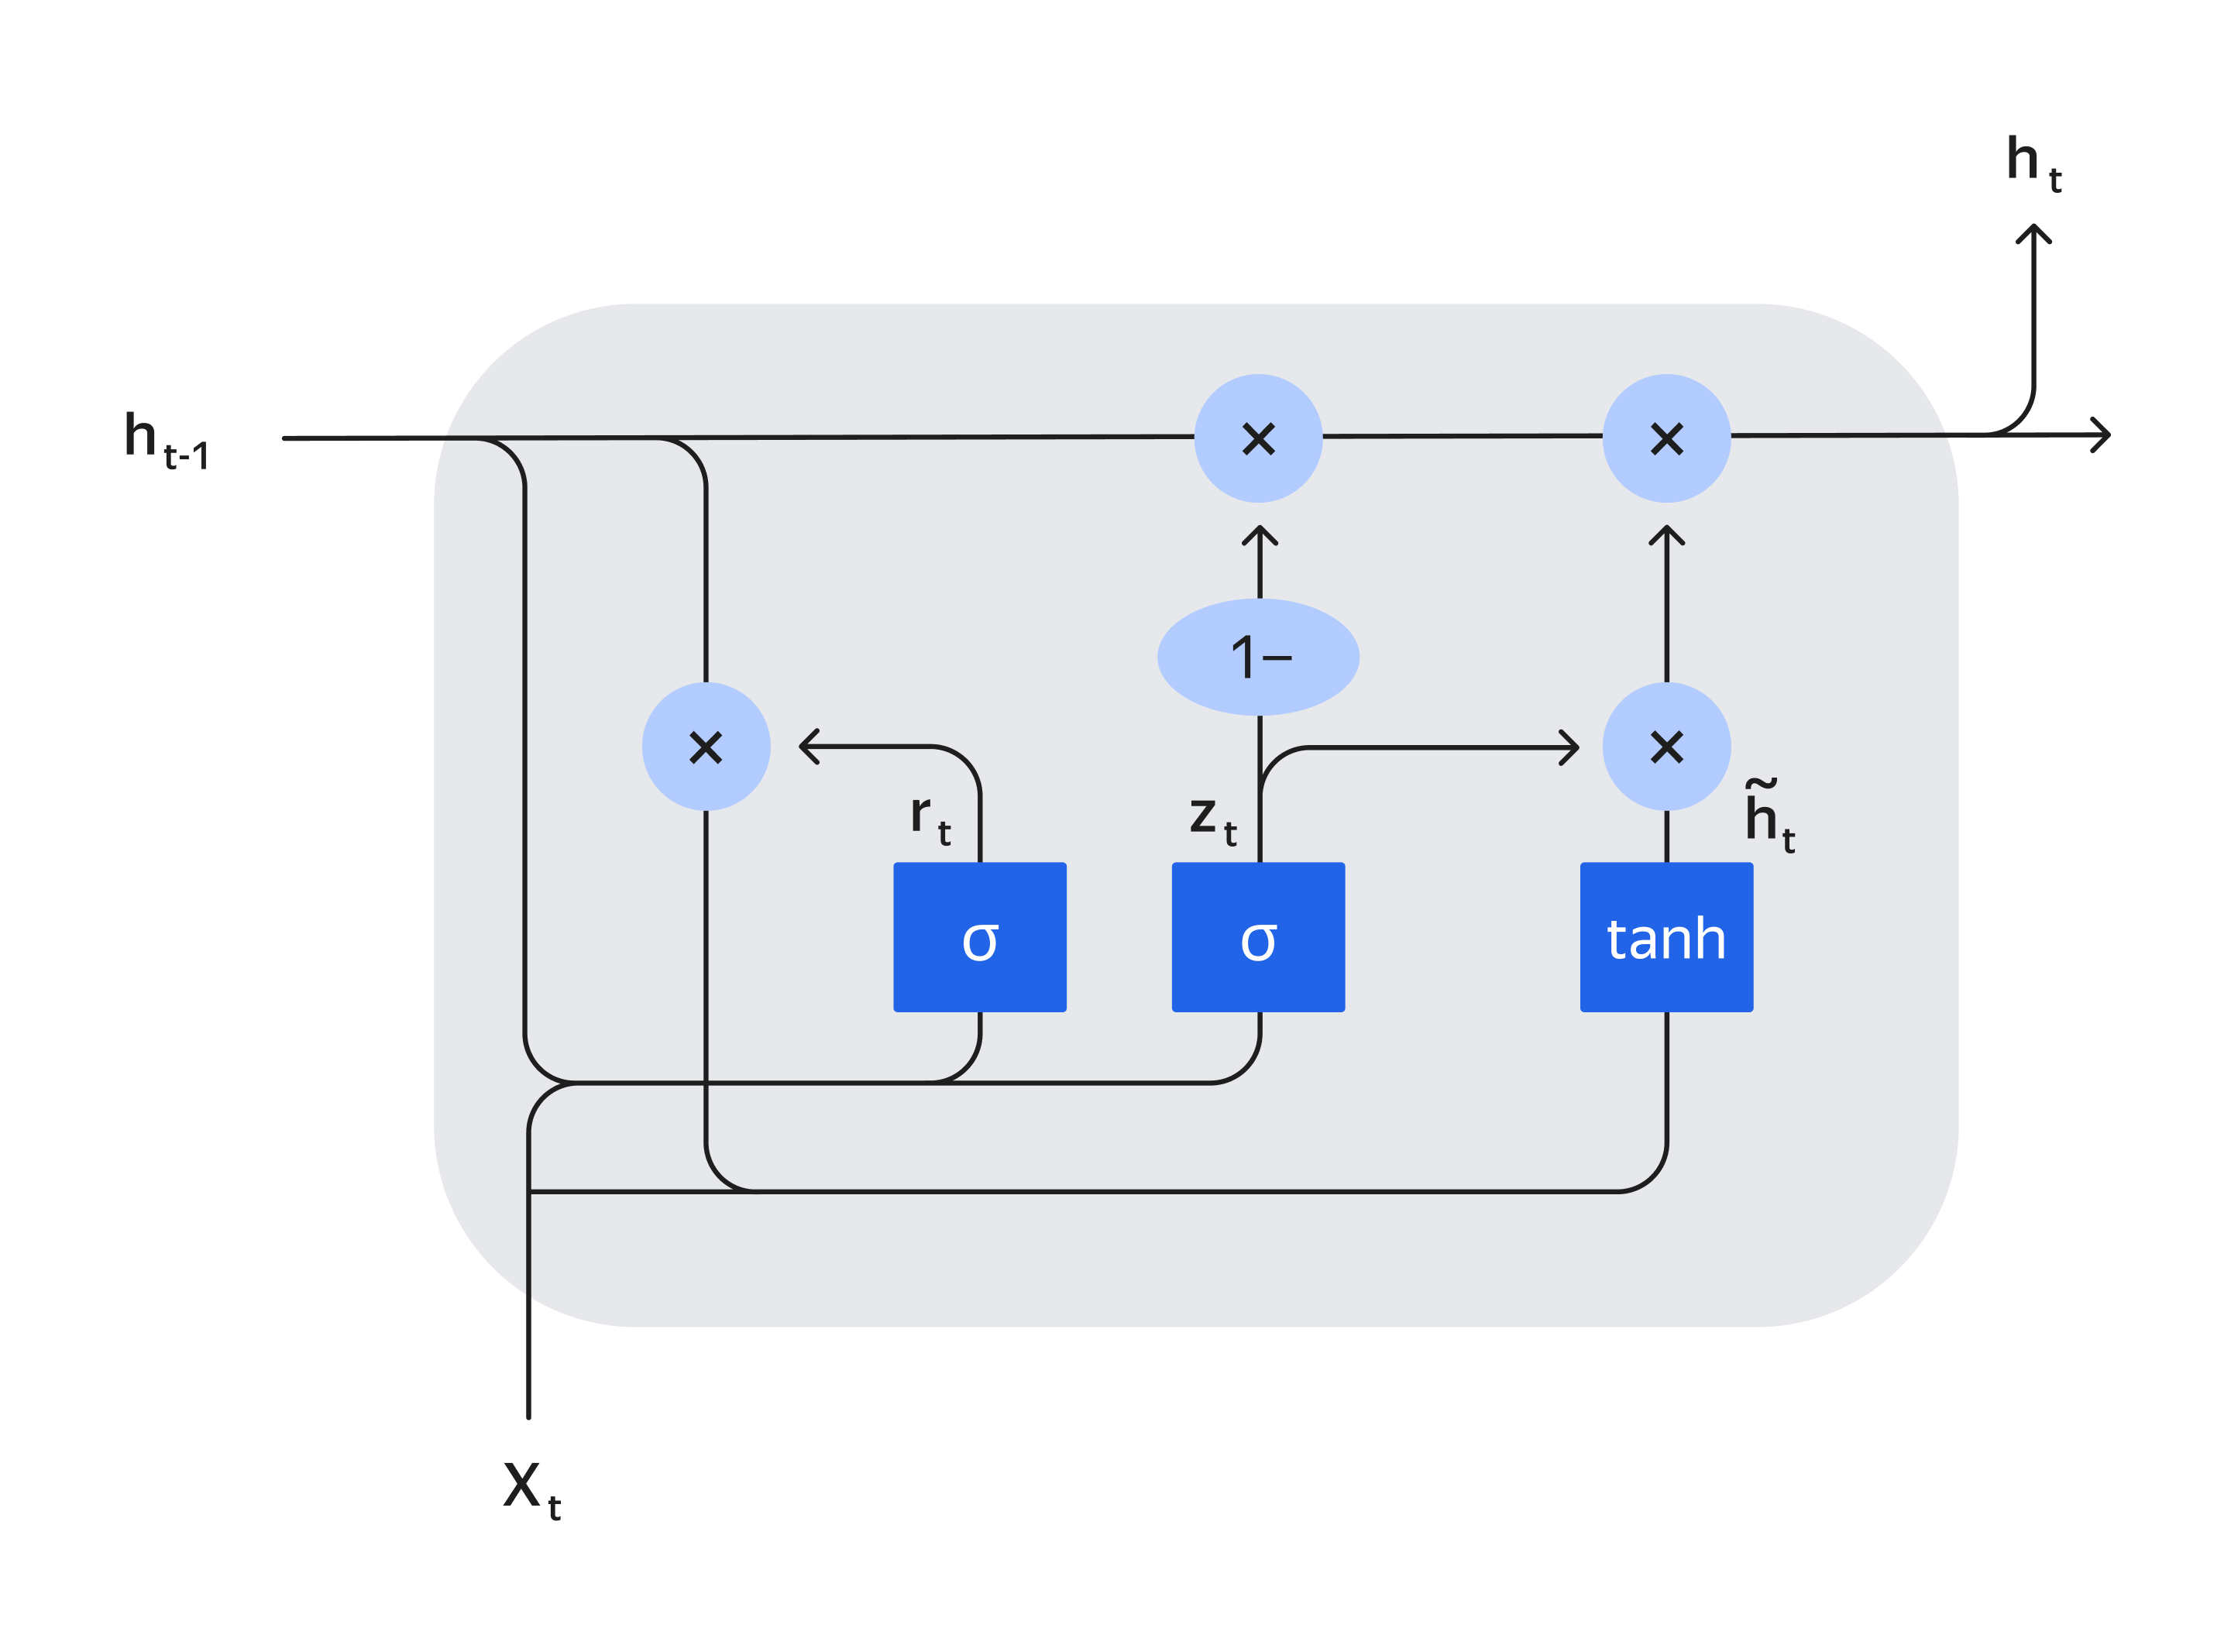

In [2]:
Image(settings.SOURCE_PATH+"ml_dl/RNN/GRU.png", width=600, height=1000)

На вход поступают текущий вектор xt​ и предыдущее скрытое состояние ht−1​.
Два гейта c сигмоидой работают так: 

    reset-гейт rt​ решает, какую часть ht−1​ «обнулить»,
    update-гейт zt​ определяет, какую долю старого состояния сохранить.
    Поэлементное произведение rt​ и ht−1​, а также вход xt​ подаются через     tanh, чтобы получить вектор h~t​.
    Итоговое скрытое состояние ht​ сочетает старое состояние и новую полезную информацию, которую сеть запомнила.

Таким образом, GRU без отдельного cell state умеет избирательно сохранять и обновлять информацию.